# Problem Set 6

See [Visualization Rules](https://datascience.quantecon.org/../applications/visualization_rules.html) and [Regression](https://datascience.quantecon.org/../applications/regression.html)

In [85]:
#! pip install patsy
# install require dependency
!pip install altair
import altair as alt

# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

This problem set uses data on insuree characteristics and medical costs. This is a public domain dataset downloaded from [kaggle](https://www.kaggle.com/mirichoi0218/insurance). 

The variables in the data are:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index of primary beneficiary
- children: Number of children covered by health insurance / Number of dependents
- smoker: whether primary beneficiary smokes
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: medical costs billed by health insurance

You will build a  model to predict charges given the other variables in the data. 


In [86]:
insure = pd.read_csv("https://raw.githubusercontent.com/doctor-phil/ECON323_2023_Spring/main/problem_sets/insurance.csv")
insure.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Questions 1-3

These question are intentionally open-ended. For each one, carefully choose the type of visualization you’ll create. Put some effort into choosing colors, labels, and other formatting.

# 留言 （看完可以删了）

> Prof said: recommended multiple plots (i.e. subplots) for each question, allowed to use other variables that is not listed/mentioned from the question

> e.g. Q1 ask for smoking & medical costs, but you could use bmi or any other variable that make sense to "SHOW relationship" between `smoking` and `medical costs`

> Q1 is kinda ready?, Q2 and Q3 is completely off (just like minimal effort)

### Question 1

Create a visualization showing the relationship between smoking and medical costs. 

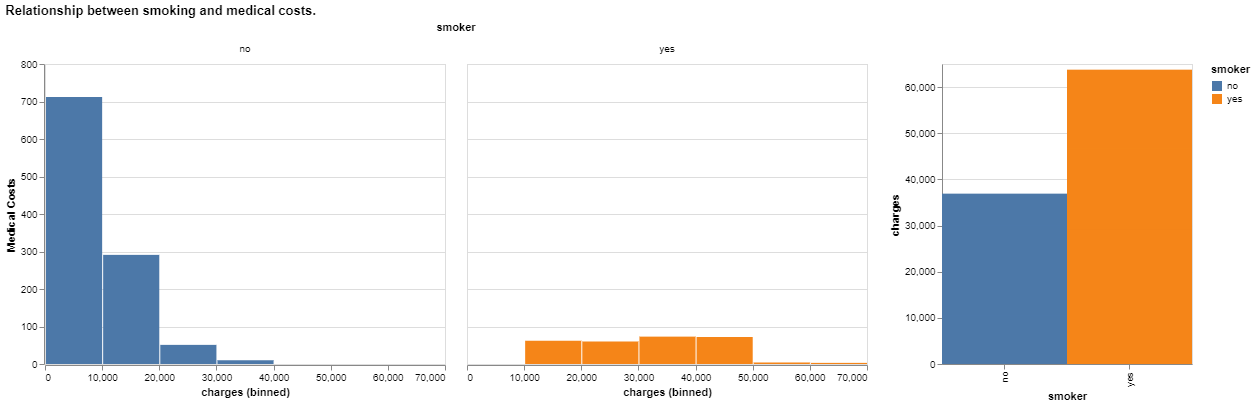

In [87]:
# visualization showing the relationship between smoking (binary) and medical costs (numeric).
# insure.pivot(columns='smoker', values='charges').plot.hist(bins = 25, alpha=0.5)
# plt.xlabel('Medical Costs (In dollar)')
# plt.ylabel('Counts')
# plt.legend(title="Smoker (Yes or No)")
# plt.show()

def smoke_costs(data):
    hist = alt.Chart(data).mark_bar().encode(
        x = alt.X("charges:Q", bin=True),
        y = alt.Y("count()", sort="-x", title="Medical Costs"),
        color = "smoker:N"
    ).facet(
        facet="smoker"
    )
    
    scatter = alt.Chart(data).mark_rect().encode(
        x = alt.X("smoker:N"),
        y = alt.Y("charges:Q"),
        color = "smoker"
    ).properties(
        width = 250
    )
    
    output = (hist | scatter).properties(
        title = "Relationship between smoking and medical costs."
    )
    return output
q1_plot = smoke_costs(data=insure)
q1_plot

### Question 2

Create a visualization showing the relationship between BMI and medical costs. 

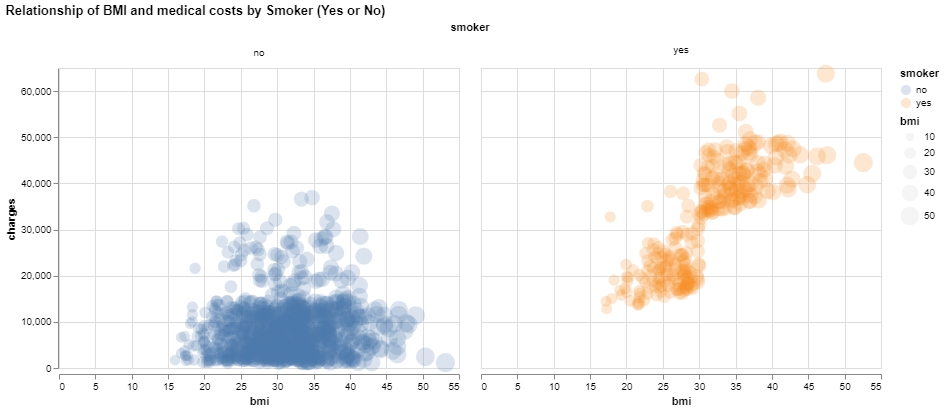

In [88]:
# your code here

# showing the relationship between BMI and medical costs.
def bmi_costs(data):
    output = alt.Chart(data).mark_circle(opacity=0.2).encode(
        x = alt.X("bmi"),
        y = alt.Y("charges"),
        size = "bmi",
        color = "smoker"
    ).facet(
        facet = "smoker"
    )
    
    
    return output
#fig, ax = plt.subplots()
#ax.scatter(x = insure["bmi"], y = insure["charges"])
q2_plot = bmi_costs(data=insure).properties(title="Relationship of BMI and medical costs by Smoker (Yes or No)")
q2_plot 


### Question 3

Does the relationship between medical costs and BMI vary with gender? Create a visualization to answer this question.

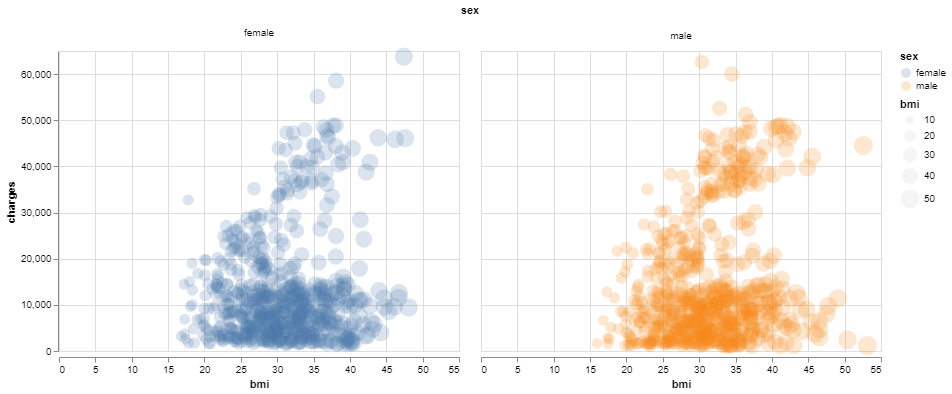

In [89]:
# your code here

# Does the relationship between medical costs and BMI vary with gender
def bmi_sex_costs(data):
    output = alt.Chart(data).mark_circle(opacity=0.2).encode(
        x = alt.X("bmi"),
        y = alt.Y("charges"),
        size = "bmi",
        color = "sex"
    ).facet(
        facet = "sex"
    )
    
    return output
    
q3_plot = bmi_sex_costs(data=insure)
q3_plot

## Questions 4-7

In these questions you will build and evaluate a model to predict medical costs. 

First, we divide the data into training and testing sets. 

# 留言（看完可以删了）

> There is common function `report_mses` that is being applied to almost all of Q4-7, check the comments/doc I left to know that it does
>
> Q4 is basically done
>
> Q5 Im not completely sure, the `alpha` instructor team did not specify it, so use default of 1.0. Then for the viz part, prof said we should use like a range of alphas to plot it out

> Q6 is basically done, check typo/any thing not making sense to you in the markdown

> Q7 checked with prof, he said he doesnt know why the alpha is different from the plot method and from the `LassoCV` function from `sklearn`. And said that use either of the method is fine. (我觉得直接用`LassoCV`最好), plot method is very messy (code from lecture notes...). **AND:**

> REMEMBER TO ANSWER THE MARKDOWN of Q7



In [8]:
train = insure.sample(frac = 0.8,random_state = 42) 
test = insure.drop(train.index)

Now we create a numeric matrix of features from our dataframe. The formula interface from the patsy package is one convenient method for doing this.

In [9]:
y, X = patsy.dmatrices("charges ~ C(sex)*(age + children + C(smoker) + C(region)) + age:C(smoker)", insure, return_type='matrix')
y = y.flatten()
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

### Question 4

Fit a linear regression model to the training data. Print the MSE on the training and testing data.

In [10]:
# helper to get mses
def report_mses(mod, X_train, X_test, y_train, y_test, name):
    out = dict(
        mse_train=mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=mean_squared_error(y_test, mod.predict(X_test))
    )
    print(f"""
    The train MSE of {name} is {round(out["mse_train"], 3)}
    The test MSE of {name} is {round(out["mse_test"], 3)}
    """)
    return out

In [11]:
# your code here

# construct OLS model, fit it to the train data
ols_mod = LinearRegression().fit(X_train, y_train)

# OLS train and test mses
ols_mses = report_mses(ols_mod, X_train=X_train, X_test=X_test,
                                         y_train=y_train, y_test=y_test, name="OLS")


    The train MSE of OLS is 38781234.249
    The test MSE of OLS is 45740307.025
    


### Question 5

Fit a LASSO model to the training data. Follow along with the notes on regression to visualize the lasso path. `alpha`. Print the MSE on the training and testing data.


    The train MSE of LASSO is 38781549.541
    The test MSE of LASSO is 45709751.071
    
{'mse_train': 38781549.54087569, 'mse_test': 45709751.07084894}


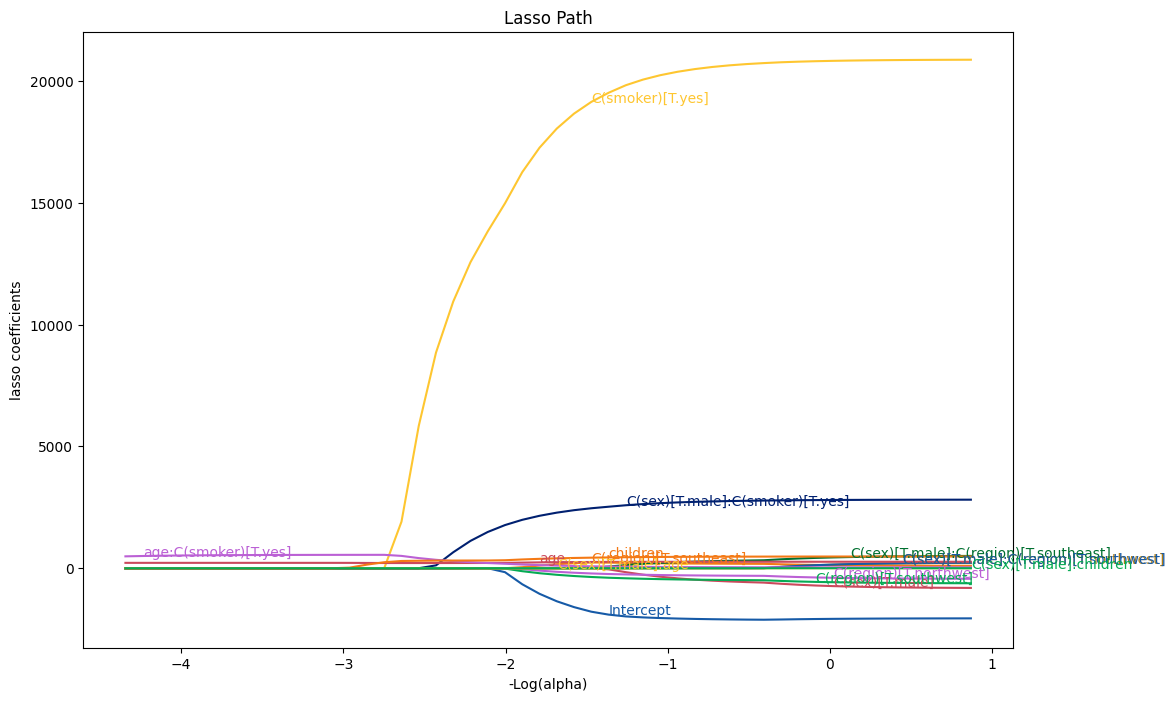

In [12]:
# your code here

# Fit LASSO model to train data, note takes default alpha=1.0
lasso_mod = Lasso().fit(X_train, y_train)

# report mses
lasso_mses = report_mses(lasso_mod, X_train=X_train, X_test=X_test,
                                         y_train=y_train, y_test=y_test, name="LASSO")
print(lasso_mses)
# Visualize the lasso path
# adoated from lecture


# plotting
def viz_lasso_alpha():
    # Compute lasso for many alphas (the lasso path)

    from itertools import cycle
    alphas = np.exp(np.linspace(10, -2, 50))
    alphas, coefs_lasso, _ = lasso_path(X, y, alphas=alphas, max_iter=10000)
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']
    color_cycle = cycle(colors)
    log_alphas = -np.log10(alphas)
    for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X.design_info.column_names)):
        ax.plot(log_alphas, coef_l, c=c)
        ax.set_xlabel('-Log(alpha)')
        ax.set_ylabel('lasso coefficients')
        ax.set_title('Lasso Path')
        ax.axis('tight')
        maxabs = np.max(np.abs(coef_l))
        i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
        xnote = log_alphas[i]
        ynote = coef_l[i]
        ax.annotate(name, (xnote, ynote), color=c)
viz_lasso_alpha()



### Question 6

Estimate a regression tree using the training, data with maximum depth of 3 layers. Set the `random_state` keyword argument to `123`. Report the mean-square error on the training and testing samples as a formatted string. 

Then estimate a regression tree with a maximum depth of 10, and the same value of `random_state` and report its MSE on the test data in the same way.

Which model had a higher MSE on the testing data? Explain why you think this might be.

In [13]:
# Estimate decision tree regressor with train data, max depth of 3, random state 123
def tree_model(X, y, max_depth, random_state=123):
    tree_mod = DecisionTreeRegressor(max_depth=max_depth, random_state=123).fit(X, y)
    return tree_mod
# report MSEs for maximum depth 3
tree_mod_max_3 = tree_model(X=X_train, y=y_train, max_depth=3)
tree_mod_max_3_mses = report_mses(mod=tree_mod_max_3, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, name="Decision Tree Regressor with max depth 3")

# report MSEs for maximum depth 10
tree_mod_max_10 = tree_model(X=X_train, y=y_train, max_depth=10)
tree_mod_max_10_mses = report_mses(mod=tree_mod_max_10, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, name="Decision Tree Regressor with max depth 10")


    The train MSE of Decision Tree Regressor with max depth 3 is 38704066.579
    The test MSE of Decision Tree Regressor with max depth 3 is 47497522.986
    

    The train MSE of Decision Tree Regressor with max depth 10 is 13277159.384
    The test MSE of Decision Tree Regressor with max depth 10 is 79878558.136
    


> Which model had a higher MSE on the testing data? Explain why you think this might be.

The **Decision Tree with maximum depth 10** had higher **test** `Mean Squared Error (MSE)`, this is because it went further (`max_depth` is bigger) with higher chances to **overfit** to the training data, hence not able to generalize patterns, thus having higher error when predicting the test data ("unseen data"). Also, we could use the results from above code:

Let $DT_{3}$ be the decision tree regressor with max depth $3$ and  $DT_{10}$ be the decision tree regressor with max depth $10$.

1. $DT_{3}$ had **higher** train MSE but **lower** test MSE.
2. $DT_{10}$ had **lower** train MSE but **higher** test MSE.

### Question 7

Perform k-fold cross-validation on the $\alpha$ parameter in your lasso regression, with $k$ equal to `5`. What is the optimal value of $\alpha$ that it chooses? Compare that value of $\alpha$ to the visualization from question 5. How many of your variables have parameters at this level of $\alpha$?

In [19]:
# # perform k fold cv on alpha, with k = 5
# def k_fold_cv_viz(k):
#     alphas = np.exp(np.linspace(-7, 7, 125))
#     mse = pd.DataFrame()
#     mse["log_alpha"] = np.log(alphas)
#     mse["cv"] = [-np.mean(cross_val_score(Lasso(alpha=alpha, max_iter=5000),
#                                       X_train, y_train, cv=k, scoring='neg_mean_squared_error'))
#               for alpha in alphas]
#     return mse

# fold_cv_5 = k_fold_cv_viz(k=5)
# optimal = fold_cv_5.loc[fold_cv_5.cv.argmin()]
# log_alpha = optimal.log_alpha
# opt_alpha = np.exp(log_alpha)
# print(f"The optimal log alpha is {round(log_alpha, 3)}, equivalent to alpha = {round(opt_alpha, 3)} with cv: {round(optimal.cv, 3)}")

In [20]:
# # create plots
# fig, ax = plt.subplots()
# fold_cv_5.plot(x="log_alpha", y="cv", c='#fec630', ax=ax)
# ax.set_xlabel(r"$\log(\alpha)$")
# ax.set_ylabel("MSE")
# # add anotation to optimal , and take inverse of natural log to get back alpha
# ax.axvline(x=log_alpha, color='red', label=r'Optimal $\alpha = $' + f'{round(opt_alpha, 3)}', ls='--')
# ax.set_title(r'5 fold CV for $\alpha$ of Lasso Regression')
# plt.legend()
# plt.show()

In [22]:
# This is using function from scikit learn
lasso = LassoCV(cv=5).fit(X_train,y_train)
np.log(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splittig

5.073285236579898

# This should answer in markdown:
> What is the optimal value of $\alpha$ that it chooses? Compare that value of $\alpha$ to the visualization from question 5. How many of your variables have parameters at this level of $\alpha$?

The optimal value of $\alpha$ it chooses is $5.07328$. Comparing the value to the visualization from question 5, this 